In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
plantsPositions = torch.rand((10000, 2), dtype=torch.float32, device=device) * 100

plantRadius = torch.tensor(0.2, device=device)

plantsPositions.shape

torch.Size([10000, 2])

In [6]:
robotPose = torch.tensor([0, 0], dtype=torch.float32, device=device)

In [ ]:
@torch.jit.script
def sdf(plantCenter, plantRadius:float, point):
    #plantCenter (NEnvs, n plants, 2)
    #point (NEnvs, 2)
    return torch.linalg.norm(plantCenter - point, dim=-1) - plantRadius

/home/airlab/miniconda3/envs/isaaclab/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([100, 100, 2])


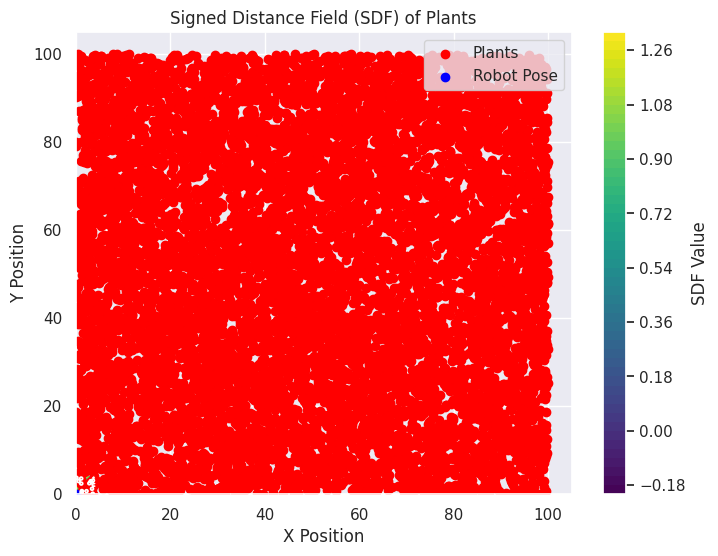

In [8]:
# Make a 3d plot of the SDF for each plant
def plot_sdf(plantPositions, plantRadius, robotPose):
    x = torch.linspace(0, 4, 100, device=device)
    y = torch.linspace(0, 4, 100, device=device)
    X, Y = torch.meshgrid(x, y)
    Z = torch.ones_like(X, device=device)*99999

    points = torch.stack([X, Y], dim=-1)
    print(points.shape)

    # Vectorized computation for all plants at once
    # points: [100, 100, 2], plantPositions: [9, 2]
    # Expand points to [1, 100, 100, 2], plantPositions to [9, 1, 1, 2]
    points_exp = points.unsqueeze(0)                # [1, 100, 100, 2]
    plants_exp = plantPositions[:, None, None, :]   # [9, 1, 1, 2]
    # Compute SDF for all plants at all points
    sdf_vals = sdf(plants_exp, plantRadius, points_exp) # [9, 100, 100]
    # relu_sdf = torch.relu(sdf_vals)
    Z, _ = torch.min(sdf_vals, dim=0)  # [100, 100]

    plt.figure(figsize=(8, 6))
    plt.contourf(X.cpu().numpy(), Y.cpu().numpy(), Z.cpu().numpy(), levels=50, cmap='viridis')
    plt.colorbar(label='SDF Value')
    plt.contour(X.cpu().numpy(), Y.cpu().numpy(), Z.cpu().numpy(), levels=[0], colors='white', linewidths=2)
    plt.scatter(plantsPositions[:, 0].cpu().numpy(), plantsPositions[:, 1].cpu().numpy(), color='red', label='Plants')
    plt.scatter(robotPose[0].item(), robotPose[1].item(), color='blue', label='Robot Pose')
    plt.title('Signed Distance Field (SDF) of Plants')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.show()

# Plot the SDF
plot_sdf(plantsPositions, plantRadius, robotPose)

Plotting raymarching paths...


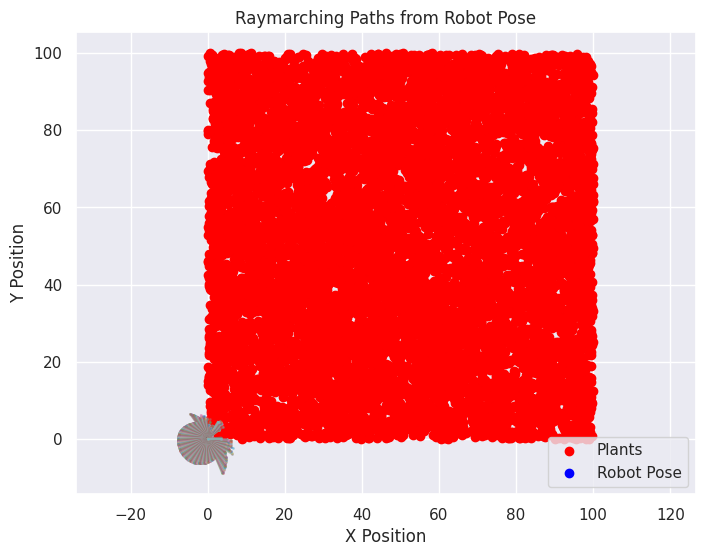

In [9]:
#Raymarching
@torch.jit.script
def raymarch(start, direction, plantsPositions, plantRadius, max_distance:float=5.0, tolerance:float=1e-2):
    position = start.clone()

    while torch.norm(position - start) < max_distance:
        # Compute the SDF for the current position
        sdf_value = torch.min(sdf(plantsPositions, plantRadius, position))
        
        # If we are inside a plant, stop marching
        if sdf_value < tolerance:
            break
        
        # Move in the direction of the ray
        position += direction * sdf_value

    return position

# Example usage of raymarching
start = robotPose
directionsAngles = torch.linspace(0, 2 * torch.pi, 360, device=device)  # 36 directions
directions = torch.stack([torch.cos(directionsAngles), torch.sin(directionsAngles)], dim=-1)

@torch.jit.script
def computePaths(start, directions, plantsPositions, plantRadius):
    paths = []
    for direction in directions:
        path = raymarch(start, direction, plantsPositions, plantRadius)
        paths.append(path)
    return paths
# Collect paths for each direction

paths = computePaths(start, directions, plantsPositions, plantRadius)

print("Plotting raymarching paths...")

# Plot the raymarching paths
def plot_raymarching(paths, robotPose):
    plt.figure(figsize=(8, 6))
    for path in paths:
        # Each path is a single point (the raymarch endpoint), so plot a line from robotPose to the endpoint
        plt.plot([robotPose[0].item(), path[0].item()], [robotPose[1].item(), path[1].item()], alpha=0.5, marker='o', markersize=1)
    
    plt.scatter(plantsPositions[:, 0].cpu().numpy(), plantsPositions[:, 1].cpu().numpy(), color='red', label='Plants')
    plt.scatter(robotPose[0].item(), robotPose[1].item(), color='blue', label='Robot Pose')
    plt.title('Raymarching Paths from Robot Pose')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Plot the raymarching paths
plot_raymarching(paths, robotPose)




In [10]:
%timeit computePaths(start, directions, plantsPositions, plantRadius)

164 ms ± 5.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
1/200 * 1000

5.0

Plotting raymarching paths...


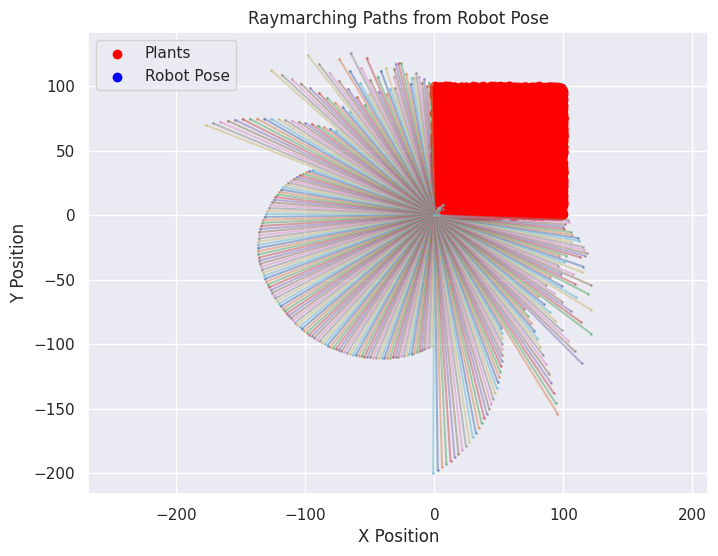

In [12]:
#Raymarching
@torch.jit.script
def raymarch_parallel(start, directions, plantsPositions, plantRadius, max_distance:float=5.0, tolerance:float=1e-2, max_steps:int=100):
    # start: [2], directions: [N, 2]
    N = directions.shape[0]
    positions = start.unsqueeze(0).repeat(N, 1)  # [N, 2]
    finished = torch.zeros(N, dtype=torch.bool, device=start.device)  # [N]
    distances = torch.zeros(N, dtype=torch.float32, device=start.device)  # [N]
    for _ in range(max_steps):
        # Compute SDF for all positions
        sdf = sdf(plantsPositions, plantRadius, positions.unsqueeze(1))  # [N, M] where M is number of plants
        # Find the minimum SDF for each ray
        sdf_min, _ = torch.min(sdf, dim=1)  # [N]


        # Find which rays are done
        hit = (sdf_min < tolerance)
        finished = finished | hit

        # Compute step size for unfinished rays
        step = directions * sdf_min.unsqueeze(1)  # [N, 2]

        # Only update unfinished rays
        positions = torch.where(finished.unsqueeze(1), positions, positions + step)

        distances = torch.where(finished, distances, distances + sdf_min)
        # Stop if all finished or max_distance reached
        if finished.all() or (distances > max_distance).all():
            break
        # Clamp positions that exceed max_distance
        over_max = distances > max_distance
        finished = finished | over_max
    return positions


# Use the parallel version
paths = raymarch_parallel(start, directions, plantsPositions, plantRadius, max_distance=100.0, tolerance=1e-2, max_steps=100)

print("Plotting raymarching paths...")

# Plot the raymarching paths
def plot_raymarching(paths, robotPose):
    plt.figure(figsize=(8, 6))
    for path in paths:
        # Each path is a single point (the raymarch endpoint), so plot a line from robotPose to the endpoint
        plt.plot([robotPose[0].item(), path[0].item()], [robotPose[1].item(), path[1].item()], alpha=0.5, marker='o', markersize=1)
    
    plt.scatter(plantsPositions[:, 0].cpu().numpy(), plantsPositions[:, 1].cpu().numpy(), color='red', label='Plants')
    plt.scatter(robotPose[0].item(), robotPose[1].item(), color='blue', label='Robot Pose')
    plt.title('Raymarching Paths from Robot Pose')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Plot the raymarching paths
plot_raymarching(paths, robotPose)




In [13]:
%timeit raymarch_parallel(start, directions, plantsPositions, plantRadius, max_distance=100, tolerance=1e-1, max_steps=100)

32.3 ms ± 240 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
1/22 * 1000

45.45454545454545

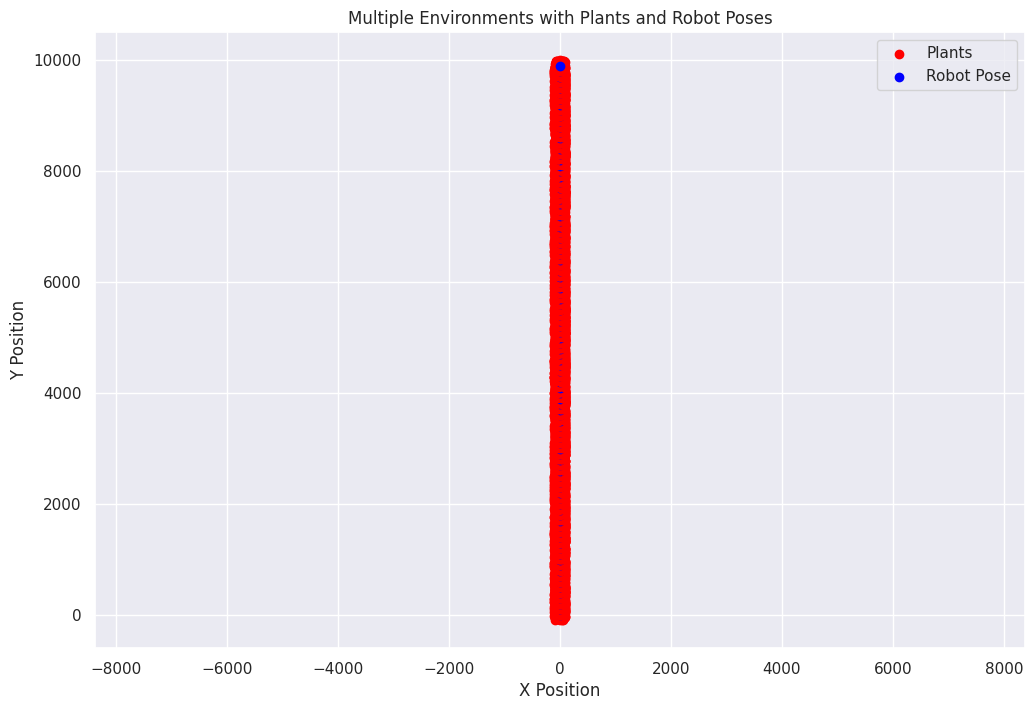

In [64]:
nEnvs = 100
nPlants = 100
directionsAngles = torch.linspace(0, 2 * torch.pi, 360, device=device)  # 36 directions
directions = torch.stack([torch.cos(directionsAngles), torch.sin(directionsAngles)], dim=-1)

envOffset = torch.Tensor([0, 100]).to(device)  # Offset for each environment
plantRadius:float = 1

plantsPositions = (2*torch.rand((nEnvs, nPlants, 2), dtype=torch.float32, device=device)-1) * 100 + envOffset * torch.arange(nEnvs, device=device).view(-1, 1, 1)

robotPoses = torch.tensor([0, 0], dtype=torch.float32, device=device)
robotPoses = robotPoses.unsqueeze(0).repeat(nEnvs, 1)  # [nEnvs, 2]
robotPoses += envOffset * torch.arange(nEnvs, device=device).view(-1, 1)  # Offset each robot pose by the environment offset

# Plot the robots and plants in the environment
def plot_environments(plantsPositions, robotPoses):
    plt.figure(figsize=(12, 8))
    for i in range(plantsPositions.shape[0]):
        plt.scatter(plantsPositions[i, :, 0].cpu().numpy(), plantsPositions[i, :, 1].cpu().numpy(), color='red', label='Plants' if i == 0 else "")
        plt.scatter(robotPoses[i, 0].item(), robotPoses[i, 1].item(), color='blue', label='Robot Pose' if i == 0 else "")
    plt.title('Multiple Environments with Plants and Robot Poses')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.axis('equal')
    plt.show()
# Plot the environments
plot_environments(plantsPositions, robotPoses)

It took 13.06 steps on average to reach the plants, with a maximum of 48.0 steps.
Plotting raymarching paths for multiple environments...


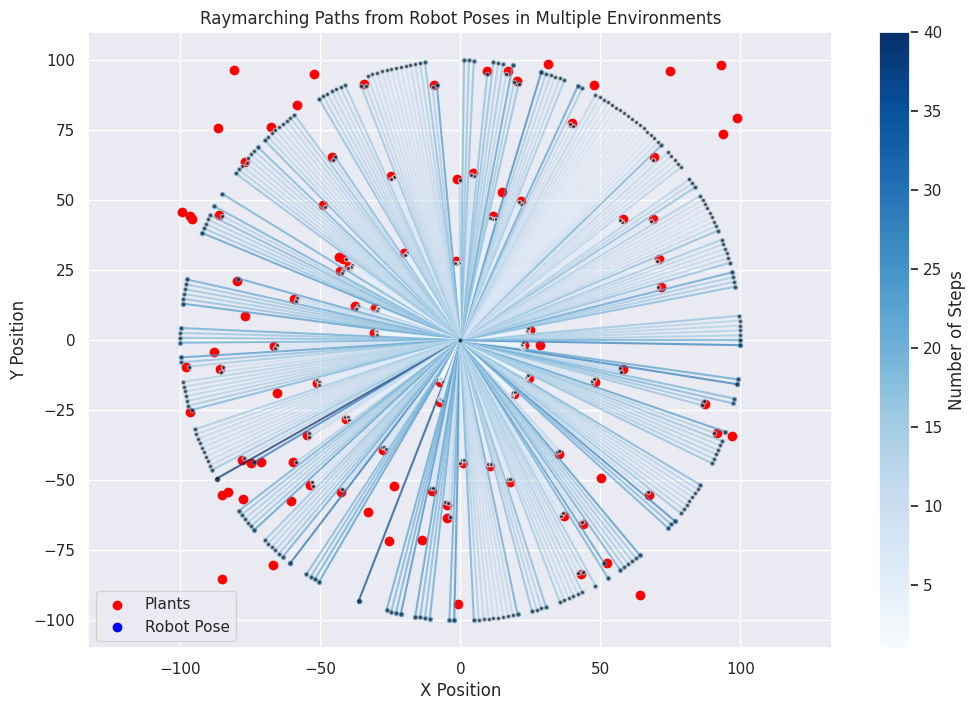

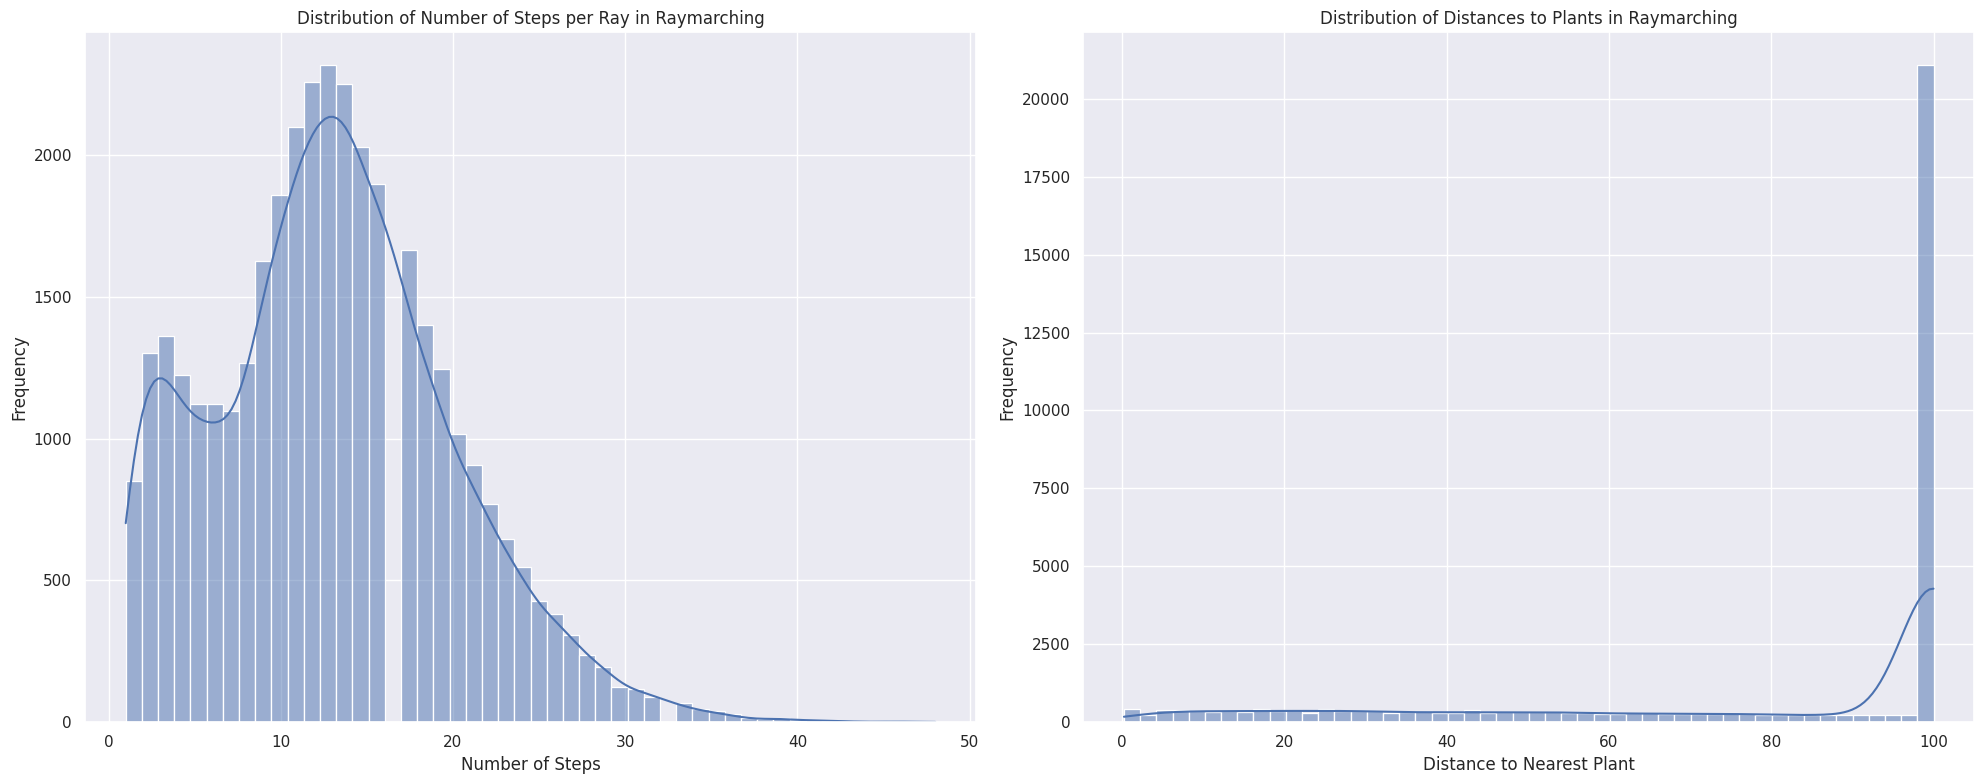

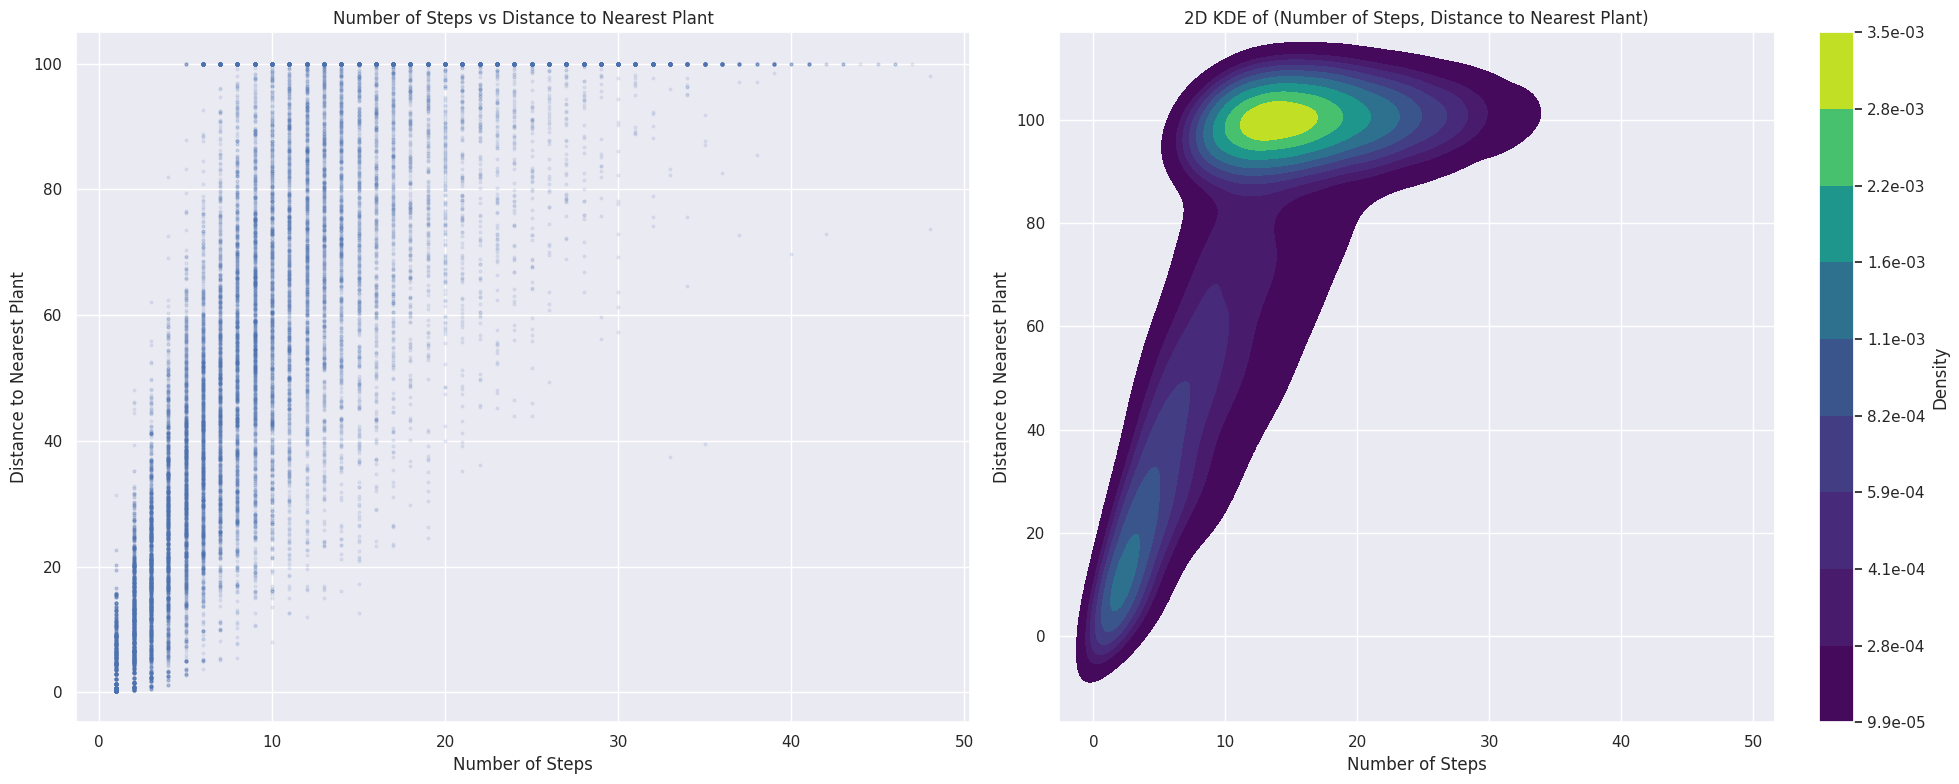

In [65]:
%matplotlib inline

# Raymarching for multiple environments
@torch.jit.script
def raymarch_parallel_multiple_envs(start, directions, plantsPositions, plantRadius:float, max_distance:float=5.0, tolerance:float=1e-2, max_steps:int=100):
    # start: [nEnvs, 2], directions: [N, 2]
    nEnvs = start.shape[0]
    N = directions.shape[0]
    positions = start.unsqueeze(1).repeat(1, N, 1) # [nEnvs, N, 2]
    finished = torch.zeros(nEnvs, N, dtype=torch.bool, device=start.device) # [nEnvs, N]
    distances = torch.zeros(nEnvs, N, dtype=torch.float32, device=start.device) # [nEnvs, N]
    nSteps = torch.zeros(nEnvs, N, dtype=torch.float32, device=start.device)  # For debugging purposes
    for _ in range(max_steps):
        # Compute SDF for all positions
        # plantsPositions: [nEnvs, nPlants, 2], positions: [nEnvs, N, 2]
        # We want to compute SDF for each environment, for each ray, for each plant
        # Expand plantsPositions to [nEnvs, 1, nPlants, 2], positions to [nEnvs, N, 1, 2]
        sdf_vals = sdf(plantsPositions.unsqueeze(1), plantRadius, positions.unsqueeze(2))  # [nEnvs, N, nPlants]
        # Find the minimum SDF for each ray
        sdf_min, _ = torch.min(sdf_vals, dim=2) # [nEnvs, N]
        # Find which rays are done
        hit = (sdf_min < tolerance)
        finished = finished | hit
        # Compute step size for unfinished rays
        step = directions.unsqueeze(0) * sdf_min.unsqueeze(-1)
        # Only update unfinished rays
        positions = torch.where(finished.unsqueeze(-1), positions, positions + step)
        distances = torch.where(finished, distances, distances + sdf_min)
        nSteps = nSteps + (~finished).float()  # Count steps for debugging
        # Stop if all finished or max_distance reached
        if finished.all() or (distances > max_distance).all():
            break
        # Clamp positions that exceed max_distance
        over_max = distances > max_distance
        distances = torch.where(over_max, max_distance, distances)
        positions = torch.where(over_max.unsqueeze(-1), start.unsqueeze(1).repeat(1, N, 1) + directions * max_distance, positions)
        finished = finished | over_max

    return positions, distances, nSteps

raymarch_parallel_multiple_envs = torch.compile(raymarch_parallel_multiple_envs)

# Use the parallel version for multiple environments
paths, distances, nsteps = raymarch_parallel_multiple_envs(robotPoses, directions, plantsPositions, plantRadius, max_distance=100.0, tolerance=1e-1, max_steps=100)
print(f"It took {nsteps.mean().item():.2f} steps on average to reach the plants, with a maximum of {nsteps.max().item()} steps.")

print("Plotting raymarching paths for multiple environments...")

# Plot the raymarching paths for multiple environments
def plot_raymarching_multiple_envs(paths, robotPoses, plantsPositions):
    plt.figure(figsize=(12, 8))
    # Flatten for easier plotting
    env_idx = 0  # Plot only the first environment for clarity
    n_rays = paths.shape[1]
    # Normalize nsteps for colormap
    nsteps_env = nsteps[env_idx].cpu().numpy()
    nsteps_norm = (nsteps_env - nsteps_env.min()) / (nsteps_env.max() - nsteps_env.min() + 1e-8)
    cmap = plt.get_cmap('Blues')  # Use a colormap for better visualization

    for j in range(n_rays):
        path = paths[env_idx, j].cpu().numpy()
        color = cmap(nsteps_norm[j])
        plt.plot(
            [robotPoses[env_idx, 0].item(), path[0]],
            [robotPoses[env_idx, 1].item(), path[1]],
            alpha=0.7, marker='o', markersize=3, color=color, markerfacecolor='black'
        )

    # Add a colorbar for nsteps
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=nsteps_env.min(), vmax=nsteps_env.max()))
    sm.set_array([])
    # Fix for ValueError: explicitly provide the current axis for colorbar
    cbar = plt.colorbar(sm, ax=plt.gca(), label='Number of Steps')
    
    for i in range(1):
        plt.scatter(plantsPositions[i, :, 0].cpu().numpy(), plantsPositions[i, :, 1].cpu().numpy(), color='red', label='Plants' if i == 0 else "")
        plt.scatter(robotPoses[i, 0].item(), robotPoses[i, 1].item(), color='blue', label='Robot Pose' if i == 0 else "")
    
    plt.title('Raymarching Paths from Robot Poses in Multiple Environments')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.axis('equal')
    plt.show()

    # Plot the distribution of number of steps per ray and distances to plants in the same figure
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    # Histogram: Number of Steps per Ray
    sns.histplot(nsteps.flatten().cpu().numpy(), bins=50, kde=True, ax=axs[0])
    axs[0].set_title('Distribution of Number of Steps per Ray in Raymarching')
    axs[0].set_xlabel('Number of Steps')
    axs[0].set_ylabel('Frequency')

    # Histogram: Distances to Plants
    sns.histplot(distances.flatten().cpu().numpy(), bins=50, kde=True, ax=axs[1])
    axs[1].set_title('Distribution of Distances to Plants in Raymarching')
    axs[1].set_xlabel('Distance to Nearest Plant')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Plot number of steps vs distance to nearest plant and 2D KDE in the same figure
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    # Scatter plot: Number of Steps vs Distance to Nearest Plant
    axs[0].plot(nsteps.flatten().cpu().numpy(), distances.flatten().cpu().numpy(), 'o', alpha=0.1, markersize=2)
    axs[0].set_title('Number of Steps vs Distance to Nearest Plant')
    axs[0].set_xlabel('Number of Steps')
    axs[0].set_ylabel('Distance to Nearest Plant')

    # 2D KDE plot
    kde = sns.kdeplot(
        x=nsteps.flatten().cpu().numpy(),
        y=distances.flatten().cpu().numpy(),
        fill=True, cmap='viridis', thresh=0.05, ax=axs[1]
    )
    axs[1].set_title('2D KDE of (Number of Steps, Distance to Nearest Plant)')
    axs[1].set_xlabel('Number of Steps')
    axs[1].set_ylabel('Distance to Nearest Plant')
    # Add colorbar for the KDE plot
    cbar = plt.colorbar(axs[1].collections[0], ax=axs[1], format='%.1e', label='Density')

    plt.tight_layout()
    plt.show()


# Plot the raymarching paths for multiple environments
plot_raymarching_multiple_envs(paths, robotPoses, plantsPositions)

In [70]:
import timeit

# Measure the time taken for raymarching across multiple environments
res = timeit.timeit(lambda: raymarch_parallel_multiple_envs(robotPoses, directions, plantsPositions, plantRadius, max_distance=100.0, tolerance=1e-1, max_steps=100), number=100) / 100
print(f"Average time for raymarching across multiple environments: {res:.4f} seconds")
print(f"FPS: {1 / (res):.2f}")

Average time for raymarching across multiple environments: 0.0282 seconds
FPS: 35.52


/home/airlab/miniconda3/envs/isaaclab/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


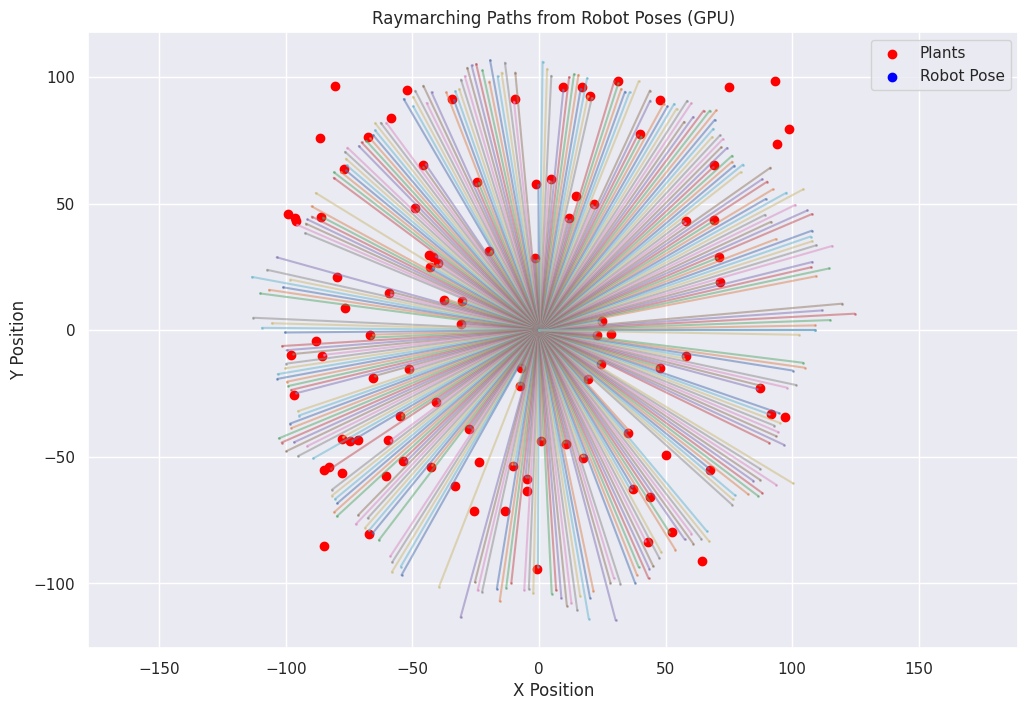

In [68]:
from numba import cuda
import numpy as np

@cuda.jit
def raymarch_2d_env_kernel(robot_poses, directions, plants_positions, plant_radius, results, max_steps, max_dist, epsilon):
    """
    Raymarching kernel for multiple environments in 2D.
    robot_poses: [n_envs, 2]
    directions: [n_rays, 2]
    plants_positions: [n_envs, n_plants, 2]
    plant_radius: float
    results: [n_envs, n_rays, 3] (x, y, hit)
    """
    env_idx = cuda.blockIdx.x
    ray_idx = cuda.threadIdx.x

    n_envs = robot_poses.shape[0]
    n_rays = directions.shape[0]
    n_plants = plants_positions.shape[1]

    if env_idx >= n_envs or ray_idx >= n_rays:
        return

    # Get robot pose and direction for this ray
    start_x = robot_poses[env_idx, 0]
    start_y = robot_poses[env_idx, 1]
    dir_x = directions[ray_idx, 0]
    dir_y = directions[ray_idx, 1]

    t = 0.0
    hit = 0
    for step in range(max_steps):
        pos_x = start_x + t * dir_x
        pos_y = start_y + t * dir_y

        # Compute SDF: minimum distance to any plant in this environment
        min_dist = 1e10
        for p in range(n_plants):
            dx = pos_x - plants_positions[env_idx, p, 0]
            dy = pos_y - plants_positions[env_idx, p, 1]
            dist = (dx*dx + dy*dy)**0.5 - plant_radius
            if dist < min_dist:
                min_dist = dist

        if min_dist < epsilon:
            hit = 1
            break
        if t > max_dist:
            break
        t += min_dist

    # Write result: endpoint x, y, hit
    results[env_idx, ray_idx, 0] = start_x + t * dir_x
    results[env_idx, ray_idx, 1] = start_y + t * dir_y
    results[env_idx, ray_idx, 2] = hit

def raymarch_2d_env(robot_poses, directions, plants_positions, plant_radius, max_steps=100, max_dist=100.0, epsilon=1e-2):
    """
    Python wrapper for the CUDA kernel.
    All inputs should be numpy arrays (float32).
    """
    n_envs = robot_poses.shape[0]
    n_rays = directions.shape[0]
    n_plants = plants_positions.shape[1]

    results = np.zeros((n_envs, n_rays, 3), dtype=np.float32)

    d_robot_poses = cuda.to_device(robot_poses.astype(np.float32))
    d_directions = cuda.to_device(directions.astype(np.float32))
    d_plants_positions = cuda.to_device(plants_positions.astype(np.float32))
    d_results = cuda.to_device(results)

    # Launch: one block per environment, one thread per ray
    threads_per_block = n_rays
    blocks_per_grid = n_envs

    raymarch_2d_env_kernel[blocks_per_grid, threads_per_block](
        d_robot_poses, d_directions, d_plants_positions, plant_radius, d_results, max_steps, max_dist, epsilon
    )

    d_results.copy_to_host(results)
    return results

# Example usage:
robot_poses_np = robotPoses.cpu().numpy().astype(np.float32)
directions_np = directions.cpu().numpy().astype(np.float32)
plants_positions_np = plantsPositions.cpu().numpy().astype(np.float32)
# Run the raymarching on GPU
results = raymarch_2d_env(robot_poses_np, directions_np, plants_positions_np, plantRadius, max_steps=100, max_dist=100.0, epsilon=1e-2)
# Convert results to torch tensor for further processing
results_tensor = torch.tensor(results, dtype=torch.float32, device=device)

# Plot the results from the GPU raymarching
def plot_raymarching_gpu(results, robotPoses, plantsPositions):
    plt.figure(figsize=(12, 8))
    for i in range(1):  # For each environment
        for j in range(results.shape[1]):  # For each ray
            path = results[i, j, :2]  # Get the endpoint of the ray
            # Plot a line from robotPose to the endpoint
            plt.plot([robotPoses[i, 0].item(), path[0].item()], [robotPoses[i, 1].item(), path[1].item()], alpha=0.5, marker='o', markersize=1)
    
        plt.scatter(plantsPositions[i, :, 0].cpu().numpy(), plantsPositions[i, :, 1].cpu().numpy(), color='red', label='Plants' if i == 0 else "")
        plt.scatter(robotPoses[i, 0].item(), robotPoses[i, 1].item(), color='blue', label='Robot Pose' if i == 0 else "")
    
    plt.title('Raymarching Paths from Robot Poses (GPU)')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.axis('equal')
    plt.show()
# Plot the raymarching paths from the GPU results
plot_raymarching_gpu(results_tensor, robotPoses, plantsPositions)


In [69]:
res = timeit.timeit(lambda: raymarch_2d_env(robot_poses_np, directions_np, plants_positions_np, plantRadius, max_steps=100, max_dist=100.0, epsilon=1e-2), number=100) / 100
print(f"Average time for GPU raymarching: {res:.4f} seconds")
print(f"FPS: {1 / (res):.2f}")

Average time for GPU raymarching: 0.1581 seconds
FPS: 6.33
